## BINNING CODE AND PLOTS 

Implemented with the help of ChatGPT

In [ ]:
import matplotlib.pyplot as plt

# Paleta
colores = {
    "azul_marino": "#0A2A43",
    "azul_petroleo": "#1B3A57",
    "azul_acero": "#2E4A6D",
    "mostaza_clasico": "#D4A017",
    "mostaza_suave": "#C79C1E"
}


## Binning used in the report

In [362]:
def binning(data, n_discard = 3000):
    """
    Binning analysis of a time series.
    Returns m, mean(m), sX(m)=sqrt(Var(binned data)), Var(binned data)
    """

    data = data[n_discard:]
    
    m = 1
    limit_m= 22500
    sizes = []
    means = []
    sX_list = []
    delta_sX_list=[]
    Nm_list = []
    
    mean_value=np.mean(data)

    data_block = data.copy() # for saving data in blocks


    while len(data_block) >= 2: 

        mean_block = mean_value
        var_block = np.var(data_block, ddof = 1) # divide entre N-1
        sX = np.sqrt(var_block / len(data_block)) 
        # error de la media (dividir entre tamaño del bloque) 
        Nm=len(data_block)
        delta_sX = sX / np.sqrt(2*(Nm - 1))
        
        sizes.append(m)
        means.append(mean_block)
        sX_list.append(sX)
        delta_sX_list.append(delta_sX)
        Nm_list.append(Nm)

        if m>= limit_m: 
            break

        # binning 
        n = len(data_block) // 2
        data_block = 0.5 * (data_block[:2*n:2] + data_block[1:2*n:2])
        m *=2 


    return sizes, means, sX_list, delta_sX_list, Nm_list 

#the following function was implemented with the help of ChatGPT
def detect_plateau(sX_list, delta_sX_list, Nm_list, k=2, window=2, Nm_min=20):
    """
    Plateau detector with the following criterion:
    |sX_i - sX_{i+j}| < k*delta_sX_i
    Args:
        sX_list: uncertainties list
        delta_sX_list: uncertainty of the uncertainty list
        Nm_list: number of blocks list
        k: compayibility criterion (default=2)
        window: window+1 consecutive compatible values to accept the plateau
        Nm_min: minimum block number
    Returns:
        m_plateau_idx: first point of the plateau index
        sX_plateau: uncertainty
        delta_sX_plateau: uncertainty of the uncertainty
    """

    sX = np.array(sX_list)
    dsX = np.array(delta_sX_list)
    Nm = np.array(Nm_list)

    for i in range(len(sX) - window):
        if Nm[i] < Nm_min:  
            continue

        stable = True
        for j in range(1, window + 1):
            if abs(sX[i] - sX[i + j]) > k * dsX[i]:
                stable = False
                break

        if stable:
            return i, sX[i], dsX[i]
        
    if not stable:
        #if we don't reach the plateau we return the last value 
        #best approximation possible with the available data
        print("Plateau not reached")
 
# ===========================================
# 3. Modelo Genérico (solo para pintar)
# ===========================================
def model_func_general(m, a, b, tau):
    return a - b * np.exp(-m / tau)

# ===========================================
# 4. Ajuste + Plot (MODIFICADA)
# ===========================================
def plot_binning_with_fit(m_sizes, sX, dsX, filename, sigma_plateau):
    """
    Realiza un ajuste fijando 'a' al valor de sigma_plateau.
    Solo ajusta 'b' y 'tau'.
    """
    sizes_array = np.array(m_sizes)
    sX_array = np.array(sX)
    dsX_array = np.array(dsX)

    if sigma_plateau is None:
        raise ValueError("Debes pasar sigma_plateau calculado fuera de esta función")

    # ---------------------------------------------------------
    # DEFINIMOS EL MODELO RESTRINGIDO INTERNAMENTE
    # 'a' ya no es variable, es una constante (sigma_plateau)
    # ---------------------------------------------------------
    def model_fixed_plateau(m, b, tau):
        return sigma_plateau - b * np.exp(-m / tau)

    # Valores iniciales (p0) solo para b y tau
    # b: diferencia entre el plateau y el primer punto
    b0 = max(abs(sigma_plateau - sX_array[0]), 1e-6)
    # tau: estimación en la mitad de la escala
    tau0 = m_sizes[len(m_sizes)//2] 
    
    p0 = [b0, tau0]

    # Ajuste con BOUNDS para evitar tau negativo
    try:
        # bounds=([b_min, tau_min], [b_max, tau_max])
        # Forzamos a que sean positivos
        popt, pcov = curve_fit(
            model_fixed_plateau, 
            sizes_array, 
            sX_array, 
            p0=p0, 
            sigma=dsX_array, 
            absolute_sigma=True,
            bounds=([0, 0], [np.inf, np.inf]) 
        )
        
        b_fit, tau_fit = popt
        fit_success = True
        print(f"Fit parameters (Fixed a={sigma_plateau:.6e}): b={b_fit:.6e}, tau={tau_fit:.2f}")
        
    except RuntimeError:
        print("El ajuste falló.")
        fit_success = False
        b_fit, tau_fit = 0, 1

    # ---------------------------------------------------------
    # GRÁFICO
    # ---------------------------------------------------------
    plt.figure(figsize=(8,6))
    
    # 1. Datos
    plt.errorbar(m_sizes, sX, yerr=dsX, fmt='o', color='#1B3A57', markersize=5, capsize=3)
    
    # 2. Curva de Ajuste
    if fit_success:
        # Usamos model_func_general para pintar, pasando el sigma_plateau fijo
        x_fit = np.logspace(0, np.log10(max(m_sizes)*1.5), 100)
        y_fit = model_func_general(x_fit, sigma_plateau, b_fit, tau_fit)
        
        plt.plot(x_fit, y_fit, '--', color='#D4A017', linewidth=2, label=f"Fit ($\\tau={tau_fit:.1f}$)")

    # 3. Línea del Plateau
    #plt.axhline(sigma_plateau, color='green', linestyle=':', linewidth=2, label=f'Plateau fijo: {sigma_plateau:.5f}')

    plt.xscale('log')
    #plt.yscale('log')
    # evitar notacion cientifica 
    plt.ticklabel_format(axis='y', style='plain')

    plt.xlabel('$m$', fontsize=18)
    plt.ylabel(r'$\sigma_{\bar{E}}$', fontsize=18)
    
    # Ojo con el ylim hardcodeado, a veces corta datos si cambias de T
    # plt.ylim(0, 0.0013) 
    
    plt.legend(fontsize=16)
    plt.tight_layout()
    #plt.savefig("m_2_0.pdf")
    plt.show()

    # Devolvemos el plateau usado, ya que esa es nuestra sigma final
    return sigma_plateau

Cargando resultats_L_100/results_MC_ 2.6_100.txt (esto puede tardar unos segundos)...
Datos totales: 100001. Usados tras descarte: 99701
Fit parameters (Fixed a=8.769519e-05): b=2.356542e-05, tau=3.31


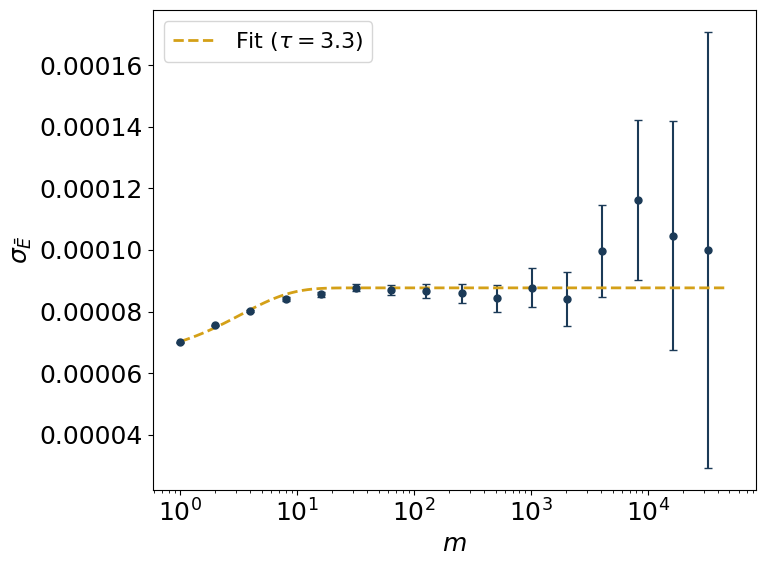


     INFORME DE VALIDACIÓN MONTE CARLO
Sistema: Ising 2D, L=100, T=2.0
Pasos Totales: 1.0e+06 MCS
Termalización: 3000 MCS descartados
--------------------------------------------------
Energía Exacta (F&F):      -1.7455571250
Energía Simulada (<E>/N):  -1.0283956751
Error Estadístico (sigma): 0.0000876952
--------------------------------------------------
Diferencia absoluta:       0.7171614499
Discrepancia en sigmas:    8177.89 σ
CONCLUSIÓN: FALLO (Discrepancia significativa, revisar código/RNG)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. PARÁMETROS DEL EJERCICIO
# =============================================================================
filename = "resultats_L_100/results_MC_2.60_100.txt"# Tu archivo con 10^8 MCS
L = 100
T = 2.0
nmeas = 10           # Mediste cada 10 pasos
mcs_discard = 3000   # El enunciado pide descartar 1000 MCS iniciales

# Valor EXACTO de Ferdinand & Fisher para L=20, T=2.0
E_exact = -1.7455571250


# =============================================================================
# 3. PROCESAMIENTO
# =============================================================================

# --- A) Carga de datos ---
print(f"Cargando {filename} (esto puede tardar unos segundos)...")
try:
    raw = np.loadtxt(filename)
    if raw.ndim == 1:
        E_data = raw
    else:
        E_data = raw[:, 0]


except OSError:
    print("ERROR: No se encuentra el archivo. Generando datos dummy...")
    N_dummy = int(1e6) 
    E_data = np.random.normal(E_exact*400, 20, N_dummy) # Dummy data

# --- B) Normalización y Descarte ---
N_spins = L * L
# Si la energía es total (aprox -700), dividir por N. Si es -1.74, dejarla.
if np.mean(E_data) < -50:
    E_data = E_data / N_spins

# Calcular filas a borrar: (1000 MCS) / (10 MCS/fila) = 100 filas
idx_discard = int(mcs_discard / nmeas)
E_clean = E_data[idx_discard:]

print(f"Datos totales: {len(E_data)}. Usados tras descarte: {len(E_clean)}")

# --- C) Análisis ---
# 1. Binning
m_sizes, means, sX, dsX, Nm = binning(E_clean)

# 2. Detectar plateau usando la función robusta
idx_plateau, sigma_plateau, dsX_plateau = detect_plateau(sX, dsX, Nm)

# 3. Ajuste y plot usando sigma_plateau detectado
sigma_final = plot_binning_with_fit(m_sizes, sX, dsX, filename, sigma_plateau=sigma_plateau)


# --- D) Comparación ---
mean_est = np.mean(E_clean)
diff = abs(mean_est - E_exact)
sigma_distance = diff / sigma_final

# =============================================================================
# 4. REPORTE EN CONSOLA (Para copiar a tu trabajo)
# =============================================================================
print("\n" + "="*50)
print("     INFORME DE VALIDACIÓN MONTE CARLO")
print("="*50)
print(f"Sistema: Ising 2D, L={L}, T={T}")
print(f"Pasos Totales: {len(E_data)*nmeas:.1e} MCS")
print(f"Termalización: {mcs_discard} MCS descartados")
print("-"*50)
print(f"Energía Exacta (F&F):      {E_exact:.10f}")
print(f"Energía Simulada (<E>/N):  {mean_est:.10f}")
print(f"Error Estadístico (sigma): {sigma_final:.10f}")
print("-"*50)
print(f"Diferencia absoluta:       {diff:.10f}")
print(f"Discrepancia en sigmas:    {sigma_distance:.2f} σ")

if sigma_distance < 1.0:
    res = "EXCELENTE (Acuerdo perfecto)"
elif sigma_distance < 2.0:
    res = "CORRECTO (Estadísticamente aceptable)"
elif sigma_distance < 3.0:
    res = "SOSPECHOSO (Bordeando el error, revisar si nMCS es bajo)"
else:
    res = "FALLO (Discrepancia significativa, revisar código/RNG)"
    
print(f"CONCLUSIÓN: {res}")
print("="*50 + "\n")



T=2.0,2.27,2.6 


INICIANDO ANÁLISIS...

--- Analizando T = 2.1 ---
  -> Promedio Magnetización (<|M|>): 1.662044
  -> Plateau detectado automáticamente: 0.00009
Fit parameters (Fixed a=9.438905e-05): b=3.441655e-05, tau=4.83


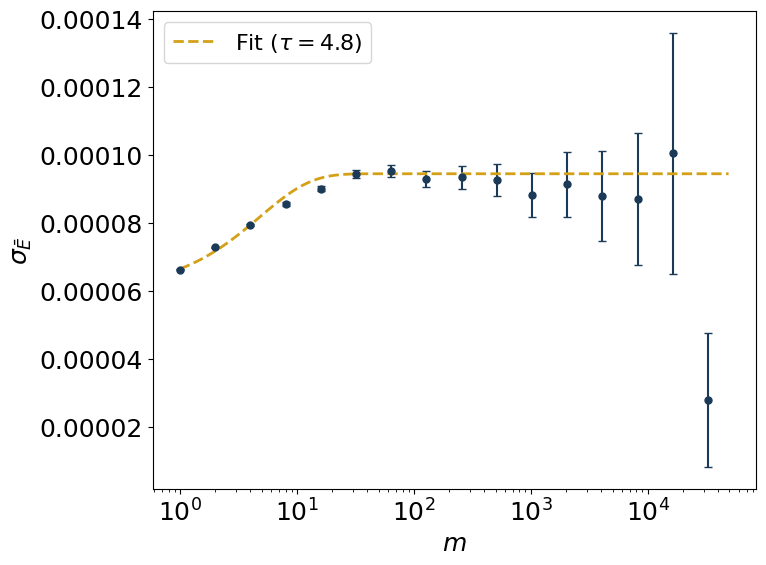


--- Analizando T = 2.2 ---
  -> Promedio Magnetización (<|M|>): 1.546580
  -> Plateau detectado automáticamente: 0.00024
Fit parameters (Fixed a=2.440816e-04): b=1.697630e-04, tau=14.61


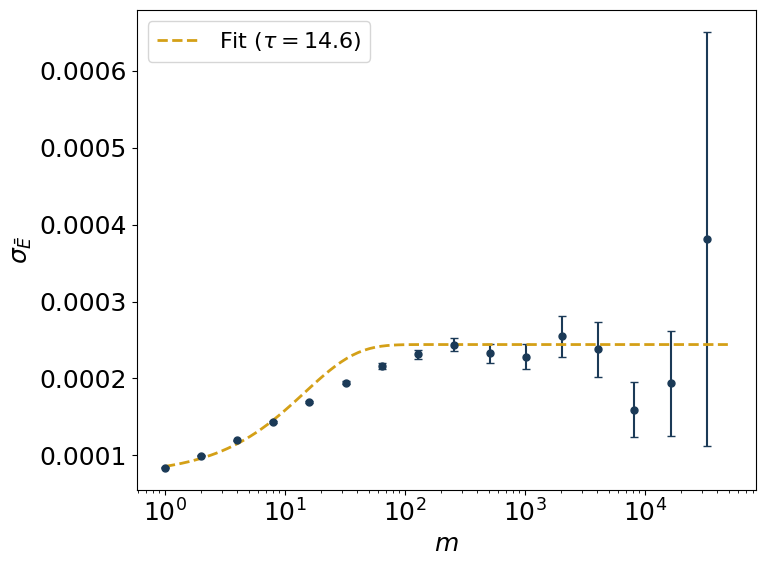


--- Analizando T = 2.3 ---
  -> Promedio Magnetización (<|M|>): 1.346606
  -> Plateau detectado automáticamente: 0.00094
Fit parameters (Fixed a=9.353806e-04): b=8.414570e-04, tau=51.59


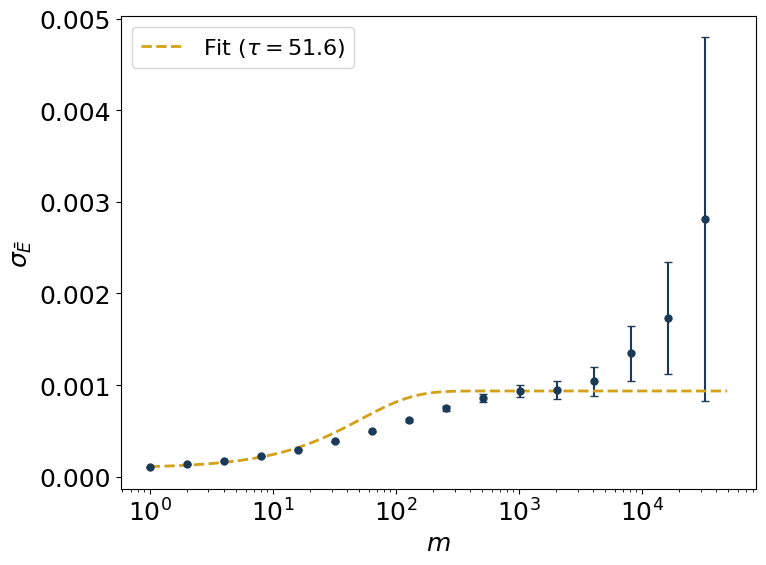


--- Analizando T = 2.4 ---
  -> Promedio Magnetización (<|M|>): 1.204028
  -> Plateau detectado automáticamente: 0.00018
Fit parameters (Fixed a=1.775470e-04): b=1.065916e-04, tau=8.98


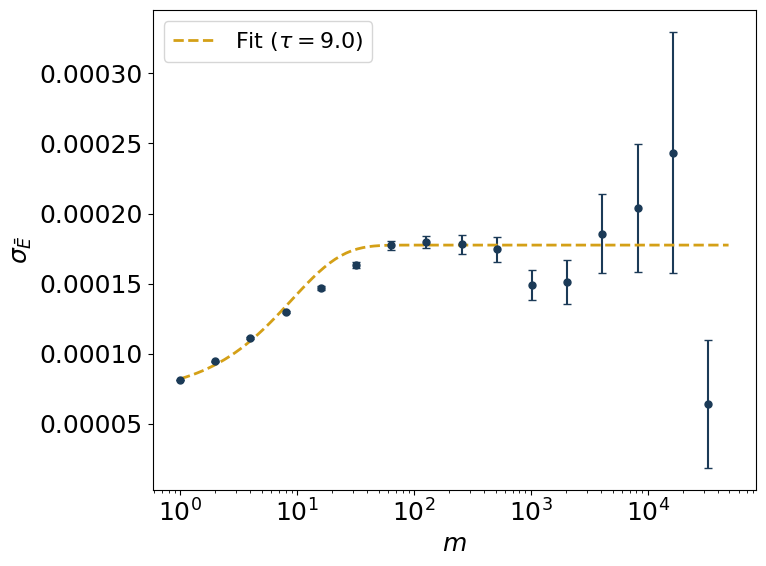


--- Analizando T = 2.5 ---
  -> Promedio Magnetización (<|M|>): 1.105969
  -> Plateau detectado automáticamente: 0.00011
Fit parameters (Fixed a=1.113009e-04): b=4.497060e-05, tau=4.87


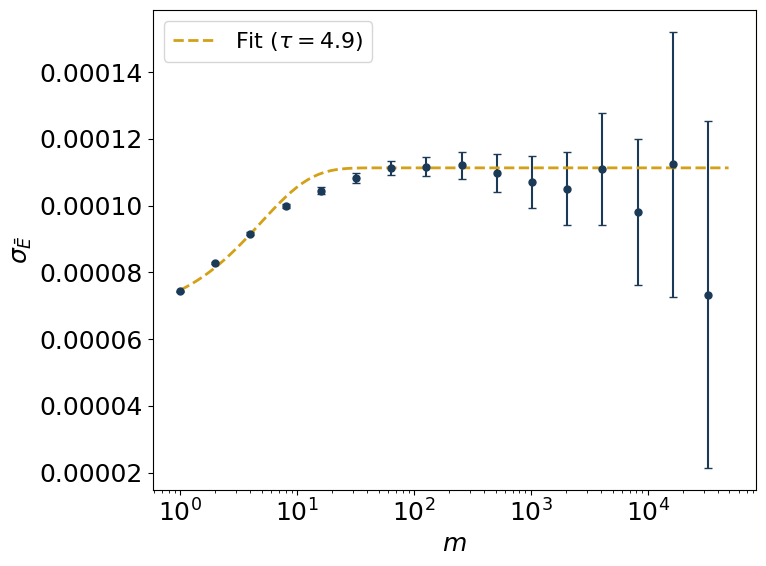


--- Analizando T = 2.7 ---
  -> Promedio Magnetización (<|M|>): 0.963638
  -> Plateau detectado automáticamente: 0.00008
Fit parameters (Fixed a=8.204074e-05): b=1.648066e-05, tau=8.44


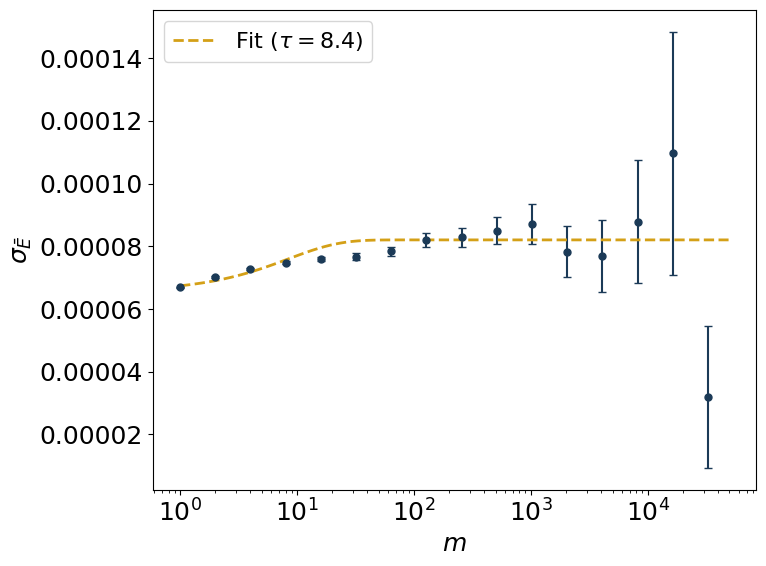


--- Analizando T = 2.8 ---
  -> Promedio Magnetización (<|M|>): 0.908090
  -> Plateau detectado automáticamente: 0.00007
Fit parameters (Fixed a=6.838910e-05): b=8.383672e-06, tau=1.40


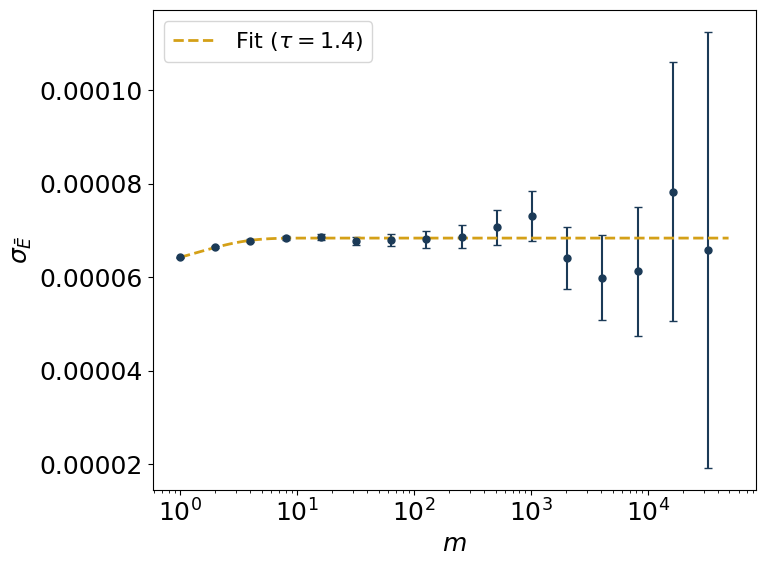


--- Analizando T = 2.9 ---
  -> Promedio Magnetización (<|M|>): 0.859940
  -> Plateau detectado automáticamente: 0.00006
Fit parameters (Fixed a=6.470467e-05): b=6.155507e-06, tau=1.00


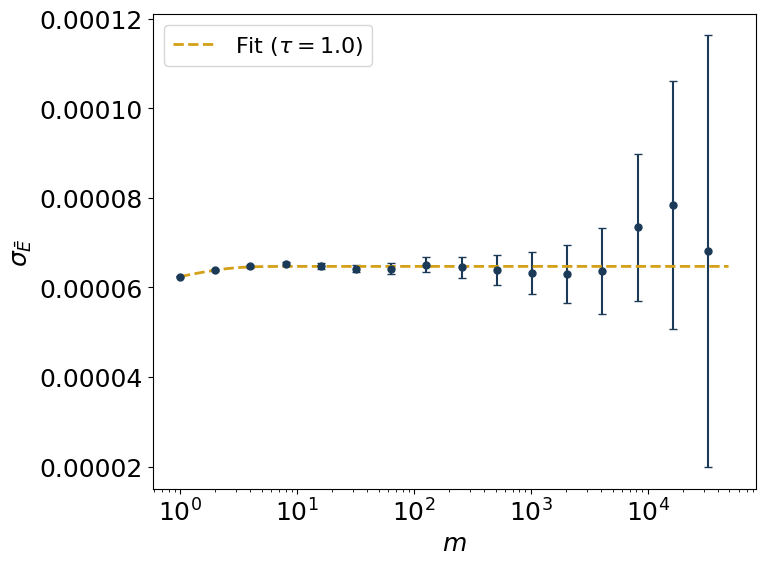


--- Analizando T = 3.0 ---
  -> Promedio Magnetización (<|M|>): 0.817328
  -> Plateau detectado automáticamente: 0.00006
Fit parameters (Fixed a=6.262742e-05): b=4.773394e-06, tau=0.96


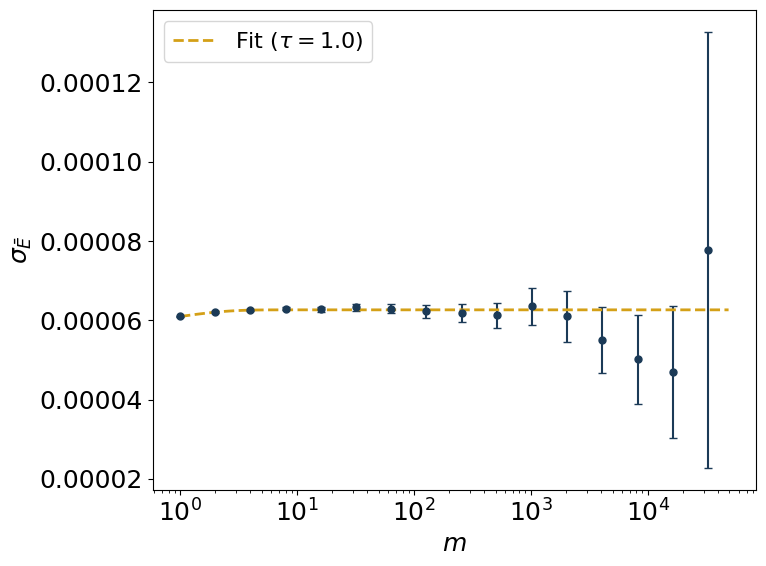

In [ ]:
import numpy as np

# =============================================================================
# 4. EJECUCIÓN PRINCIPAL
# =============================================================================

# Parámetros
folder = "resultats_L_100" 
temperatures = [2.1,2.2,2.3,2.4,2.5,2.7,2.8,2.9,3.0]
n_discard = 3000

print("INICIANDO ANÁLISIS...")

for T in temperatures:
    filename = f"{folder}/results_MC_{T}_100.txt" # Ojo al espacio extra si tu archivo lo tiene
    print(f"\n--- Analizando T = {T} ---")
    
    try:
        raw_data = np.loadtxt(filename)
        # Asumiendo Columna 1 = Magnetización. Usamos valor absoluto |M|
        data_series = np.abs(raw_data[:,0])
    except OSError:
        print(f"  No se encontró el archivo: {filename}")
        continue

    # --- NUEVO: CALCULO DE LA MEDIA (SIN DESCARTADOS) ---
    if len(data_series) > n_discard:
        data_clean = data_series[n_discard:]  # Recortamos los datos manualmente aquí
        mean_val = np.mean(data_clean)        # Calculamos el promedio
        print(f"  -> Promedio Magnetización (<|M|>): {mean_val:.6f}")
    else:
        print("  [!] Error: El archivo es más corto que n_discard.")
        continue
    # ----------------------------------------------------

    # 1. Ejecutar Binning
    # Tu función binning volverá a hacer el recorte internamente, pero eso está bien.
    m_sizes, means, sX, dsX, Nm = binning(data_series, n_discard=n_discard)
    
    # 2. Detectar Plateau Automático
    idx, val_plateau, err_plateau = detect_plateau(sX, dsX, Nm)
    
    # 3. Lógica de Decisión (Manual vs Auto)
    if T == 2.27:
        print("  [!] T Crítica detectada: Ignorando detección automática.")
        # Aquí pones el valor que ves a ojo en tu gráfica
        sigma_target = 0.011  
        print(f"  -> Forzando plateau manual: {sigma_target}")
    else:
        sigma_target = val_plateau
        print(f"  -> Plateau detectado automáticamente: {sigma_target:.5f}")

    # 4. Graficar y Ajustar (fijando 'a' = sigma_target)
    # Asegúrate de tener la función plot_binning_with_fit definida o importada
    plot_binning_with_fit(m_sizes, sX, dsX, f"T={T} (L=100)", sigma_plateau=sigma_target)

Procesando datos...

               RESULTADOS DEL ANÁLISIS (L=100)
Temperatura T = 2.0
------------------------------
  > ENERGÍA:
      Promedio (<E>/N):   -1.745666
      Error (Plateau):    0.000063
      Fit Tau:            2.46
  > MAGNETIZACIÓN:
      Promedio (<|M|>/N): 0.911343
      Error (Plateau):    0.000042
      Fit Tau:            3.90

Temperatura T = 2.27
------------------------------
  > ENERGÍA:
      Promedio (<E>/N):   -1.417889
      Error (Plateau):    0.001225
      Fit Tau:            61.40
  > MAGNETIZACIÓN:
      Promedio (<|M|>/N): 0.560000
      Error (Plateau):    0.011000
      Fit Tau:            95.61
      (Nota: Plateau M forzado manualmente)

Temperatura T = 2.6
------------------------------
  > ENERGÍA:
      Promedio (<E>/N):   -1.028400
      Error (Plateau):    0.000086
      Fit Tau:            2.73
  > MAGNETIZACIÓN:
      Promedio (<|M|>/N): 0.047357
      Error (Plateau):    0.000258
      Fit Tau:            4.70

Generando Gráficos...


C:\Users\PC\AppData\Local\Temp\ipykernel_13360\2997036699.py:230: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10000)


Gráfica guardada en: resultats_L_100/results_MC_ 2.6_100.txt.pdf


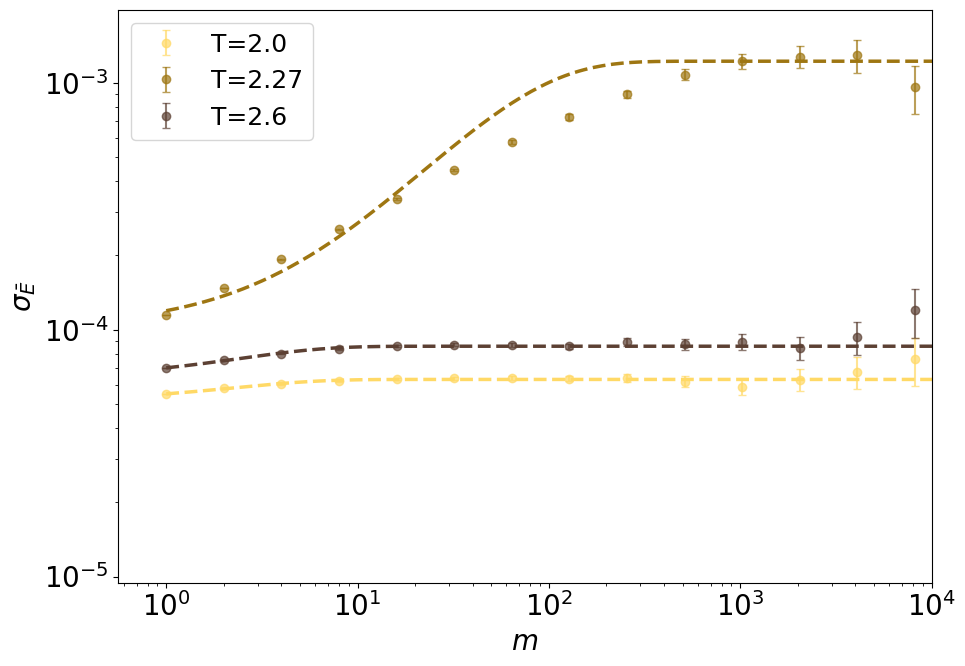

C:\Users\PC\AppData\Local\Temp\ipykernel_13360\2997036699.py:230: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10000)


Gráfica guardada en: resultats_L_100/results_MC_ 2.6_100.txt.pdf


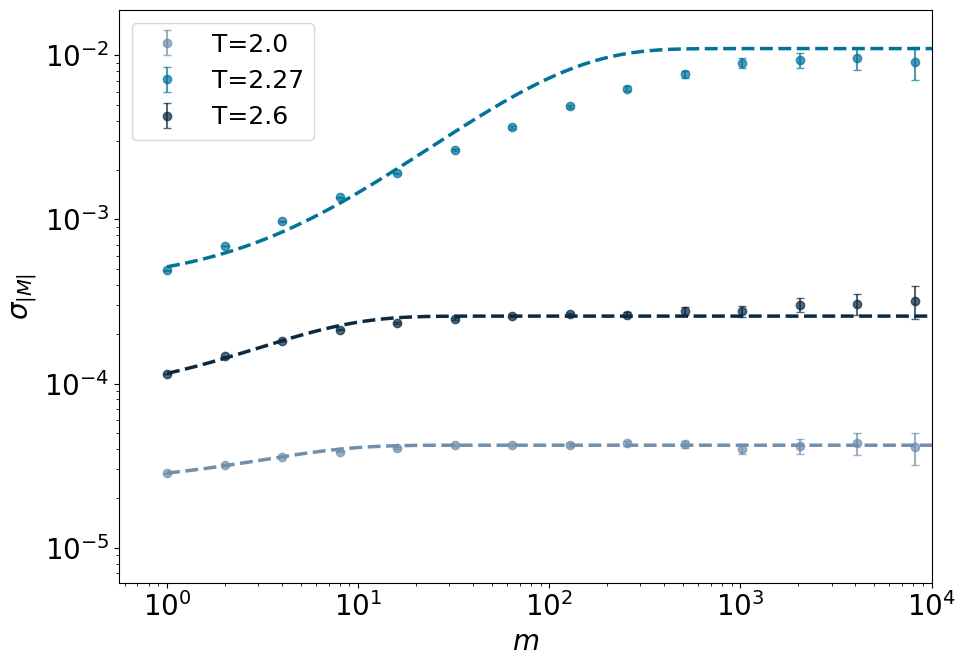

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# =============================================================================
# 1. FUNCIONES AUXILIARES
# =============================================================================

def binning(data, n_discard=3000):
    """ 
    Binning analysis of a time series.
    Returns m, mean(m), sX(m), Var(binned data), Nm_list
    """
    data = np.array(data)
    if len(data) > n_discard:
        data = data[n_discard:]
    
    m = 1
    limit_m = 22500
    sizes, means, sX_list, delta_sX_list, Nm_list = [], [], [], [], []
    
    mean_value = np.mean(data)
    data_block = data.copy()

    while len(data_block) >= 2: 
        # --- CORRECCIÓN AQUÍ: Definir mean_block ---
        mean_block = mean_value 
        
        var_block = np.var(data_block, ddof=1) 
        sX = np.sqrt(var_block / len(data_block)) 
        Nm = len(data_block)
        delta_sX = sX / np.sqrt(2*(Nm - 1))
        
        sizes.append(m)
        means.append(mean_block)
        sX_list.append(sX)
        delta_sX_list.append(delta_sX)
        Nm_list.append(Nm)

        if m >= limit_m: break

        n = len(data_block) // 2
        data_block = 0.5 * (data_block[:2*n:2] + data_block[1:2*n:2])
        m *= 2 

    return sizes, means, sX_list, delta_sX_list, Nm_list 

def detect_plateau(sX_list, delta_sX_list, Nm_list, k=2, window=2, Nm_min=20):
    """ Detecta la meseta de estabilidad """
    sX = np.array(sX_list)
    dsX = np.array(delta_sX_list)
    Nm = np.array(Nm_list)
    
    for i in range(len(sX) - window):
        if Nm[i] < Nm_min: continue
        stable = True
        for j in range(1, window + 1):
            if abs(sX[i] - sX[i + j]) > k * dsX[i]:
                stable = False
                break
        if stable: return sX[i]
            
    return sX[-1]

def model_func(m, a, b, tau):
    """ Modelo general para graficar: a - b * exp(-m/tau) """
    return a - b * np.exp(-m / tau)

def get_fit_params(m_sizes, sX, dsX, fixed_plateau):
    """ Calcula b y tau fijando a = fixed_plateau """
    sizes_array = np.array(m_sizes)
    sX_array = np.array(sX)
    dsX_array = np.array(dsX)

    # Modelo local con 'a' fijo
    def model_fixed(m, b, tau):
        return fixed_plateau - b * np.exp(-m / tau)

    try:
        # Estimaciones iniciales
        b0 = max(abs(fixed_plateau - sX_array[0]), 1e-6)
        tau0 = m_sizes[len(m_sizes)//2]
        
        # Ajuste
        popt, _ = curve_fit(model_fixed, sizes_array, sX_array, 
                            p0=[b0, tau0], sigma=dsX_array, 
                            absolute_sigma=True, bounds=([0,0],[np.inf, np.inf]))
        
        # Retorna [a, b, tau]
        return [fixed_plateau, popt[0], popt[1]]
    except:
        return None

# =============================================================================
# 2. PROCESAMIENTO DE DATOS
# =============================================================================

folder = "resultats_L_100"
temperatures = [2.00, 2.27, 2.60]
L = 100
n_discard = 3000

results_E = {} 
results_M = {}

print("Procesando datos...")

for T in temperatures:
    filename = f"{folder}/results_MC_{T}_100.txt"
    try:
        raw = np.loadtxt(filename)
        raw_E = raw[:, 0]
        raw_M = np.abs(raw[:, 1])
        
        # Promedios globales
        mean_E_global = np.mean(raw_E[n_discard:])
        mean_M_global = np.mean(raw_M[n_discard:])
        
    except Exception as e:
        print(f"Error en {filename}: {e}")
        continue

    # --- ENERGÍA ---
    m_E, _, sX_E, dsX_E, Nm_E = binning(raw_E, n_discard=n_discard)
    val_plat_E = detect_plateau(sX_E, dsX_E, Nm_E)
    params_E = get_fit_params(m_E, sX_E, dsX_E, val_plat_E)
    
    results_E[T] = {
        'm': m_E, 'sX': sX_E, 'dsX': dsX_E, 
        'mean': mean_E_global, 'plateau': val_plat_E,
        'params': params_E
    }

    # --- MAGNETIZACIÓN ---
    m_M, _, sX_M, dsX_M, Nm_M = binning(raw_M, n_discard=n_discard)
    val_plat_M = detect_plateau(sX_M, dsX_M, Nm_M)
    
    # Lógica Manual para T=2.27
    if T == 2.27:
        target_M = 0.011 
    else:
        target_M = val_plat_M
        
    params_M = get_fit_params(m_M, sX_M, dsX_M, target_M)
    
    results_M[T] = {
        'm': m_M, 'sX': sX_M, 'dsX': dsX_M, 
        'mean': mean_M_global, 'plateau': target_M,
        'params': params_M
    }

# =============================================================================
# 3. REPORTE POR PANTALLA
# =============================================================================

print("\n" + "="*70)
print(f"               RESULTADOS DEL ANÁLISIS (L={L})")
print("="*70)

for T in temperatures:
    if T not in results_E: continue
    
    rE = results_E[T]
    tau_E = rE['params'][2] if rE['params'] is not None else 0.0
    
    rM = results_M[T]
    tau_M = rM['params'][2] if rM['params'] is not None else 0.0
    
    print(f"Temperatura T = {T}")
    print("-" * 30)
    print("  > ENERGÍA:")
    print(f"      Promedio (<E>/N):   {rE['mean']:.6f}")
    print(f"      Error (Plateau):    {rE['plateau']:.6f}")
    print(f"      Fit Tau:            {tau_E:.2f}")
    
    print("  > MAGNETIZACIÓN:")
    print(f"      Promedio (<|M|>/N): {rM['mean']:.6f}")
    print(f"      Error (Plateau):    {rM['plateau']:.6f}")
    print(f"      Fit Tau:            {tau_M:.2f}")
    if T == 2.27: print("      (Nota: Plateau M forzado manualmente)")
    print("")

print("="*70)

# =============================================================================
# 4. GRAFICADO COMBINADO
# =============================================================================

def make_combined_plot(results_dict, title, ylabel, palette_name):
    plt.figure(figsize=(10, 7))
    
    # MOSTAZA (Energía):
    # 1. Amarillo Dorado (Luz)
    # 2. #D4A017 (Tu Mostaza Referencia)
    # 3. Marrón Bronce
    # 4. Marrón Café (Oscuro - para contraste fuerte)
    mustard_palette = ['#FFD966', '#9E7612', '#5C4033'] 
    
    # PETRÓLEO (Magnetización):
    # 1. #6F8FAE (Tu Acero Referencia)
    # 2. Azul intermedio apagado
    # 3. Azul Petróleo intermedio
    # 4. #0A2A43 (Tu Petróleo Referencia)
    petrol_palette = ['#6F8FAE','#007399', '#0A2A43']
    
    colors = mustard_palette if palette_name == 'mustard' else petrol_palette
    sorted_keys = sorted(results_dict.keys()) 
    
    for i, T in enumerate(sorted_keys):
        res = results_dict[T]
        m_vals = res['m']
        sX_vals = res['sX']
        dsX_vals = res['dsX']
        params = res['params']
        
        c = colors[i % len(colors)]
        
        # Puntos experimentales
        plt.errorbar(m_vals, sX_vals, yerr=dsX_vals, fmt='o', color=c, 
                     alpha=0.7, capsize=3, markersize=6, label=f'T={T}')
        
        # Fit (discontinuo)
        if params is not None:
            a, b, tau = params
            x_fit = np.logspace(0, np.log10(max(m_vals)*3), 200)
            y_fit = model_func(x_fit, a, b, tau)
            plt.plot(x_fit, y_fit, '--', color=c, linewidth=2.5)

    plt.xscale('log')
    plt.xlim(0,10000)
    plt.yscale('log')
    plt.xlabel('$m$', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=18, loc='best', frameon=True)
    plt.tight_layout()
    save_path = f"{filename}.pdf"
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Gráfica guardada en: {save_path}")
    
    plt.show()

# --- GENERAR PLOTS ---
print("Generando Gráficos...")

make_combined_plot(results_E, f"Error Binning - Energy (L={L})", r"$\sigma_{\bar{E}}$", 'mustard')
make_combined_plot(results_M, f"Error Binning - Magnetization (L={L})", r"$\sigma_{|M|}$", 'petrol')

## Autocorrelations

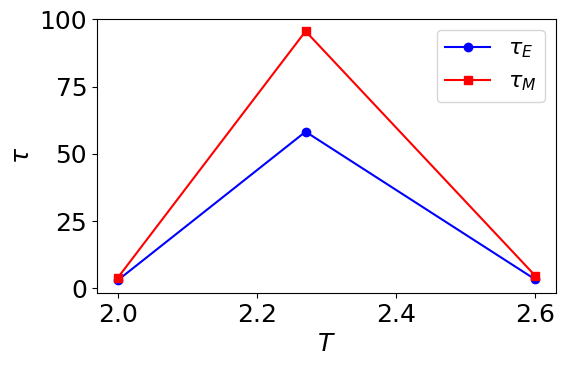

In [ ]:
import matplotlib.pyplot as plt

# Temperaturas
T = [2.00, 2.27, 2.60]

# Autocorrelación
tau_E = [2.97, 58.23, 3.31]
tau_M = [3.90, 95.61, 4.70]


plt.figure(figsize=(6,4))

# Graficar energía
plt.plot(T, tau_E, 'o-', label=r'$\tau_E$', color='blue')

# Graficar magnetización
plt.plot(T, tau_M, 's-', label=r'$\tau_M$', color='red')

# Etiquetas
plt.xlabel('$T$')
plt.ylabel(r'$\tau$')
plt.legend()

plt.show()


## E and M as a function of T

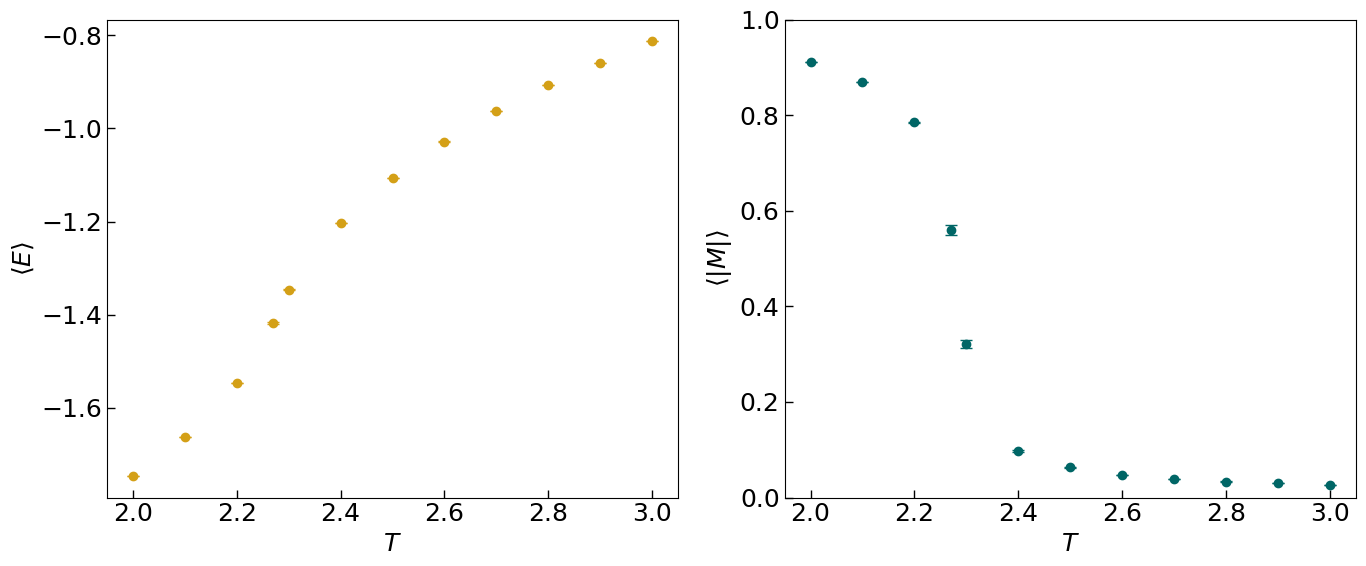

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------
# Datos (EDITA AQUÍ)
# -----------------------------
T = [2.00, 2.10, 2.20, 2.27, 2.30, 2.40, 2.50, 2.60, 2.70, 2.80, 2.90,3.00]

E = [
    -1.74567,   # 2.0
    -1.662044,  # 2.1
    -1.546580,  # 2.2
    -1.4179,    # 2.27
    -1.346606,  # 2.3
    -1.204028,  # 2.4
    -1.105969,  # 2.5
    -1.028396,   # 2.6
    -0.963638,  # 2.7
    -0.908090,  # 2.8
    -0.859940,  # 2.9
    -0.81328   # 3.0
]

sigma_E = [
    0.00006,  # 2.0
    0.00009,  # 2.1
    0.00024,  # 2.2
    0.0012,   # 2.27
    0.00094,  # 2.3
    0.00018,  # 2.4
    0.00011,  # 2.5
    0.00009,  # 2.6
    0.00008,  # 2.7
    0.00007,  # 2.8
    0.00006,
    0.00006    # 2.9
]


M = [
    0.91134,    # 2.0
    0.868733,   # 2.1
    0.784621,   # 2.2
    0.560,      # 2.27
    0.320709,   # 2.3
    0.097490,   # 2.4
    0.063353,   # 2.5
    0.04736,    # 2.6
    0.039083,   # 2.7
    0.033632,   # 2.8
    0.030049,   # 2.9
    0.027250    # 3.0
]

sigma_M = [
    0.00004,    # 2.0
    0.00010,    # 2.1
    0.00062,    # 2.2
    0.011,      # 2.27
    0.00834,    # 2.3
    0.00121,    # 2.4
    0.00055,    # 2.5
    0.00026,    # 2.6
    0.00016,    # 2.7
    0.00013,    # 2.8
    0.00009,    # 2.9
    0.00008     # 3.0
]
# -----------------------------
# Configuración global de fuentes
# -----------------------------
plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16
})


# -----------------------------
# Figura con 2 paneles
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# -------- Panel 1: Energía --------
axes[0].errorbar(
    T, E,
    yerr=sigma_E,
    fmt='o',
    capsize=4,
    color= "#D4A017"  # Color mostaza
)

axes[0].set_xlabel(r'$T$')
axes[1].set_ylim(-1.8,-0.8)
axes[0].set_ylabel(r'$\langle E \rangle$')

# -------- Panel 2: Magnetización --------
axes[1].errorbar(
    T, M,
    yerr=sigma_M,
    fmt='o',
    capsize=4,
    color= "#006666"  # Color petroleo
)

axes[1].set_xlabel(r'$T$')
axes[1].set_ylim(0,1)
axes[1].set_ylabel(r'$\langle |M| \rangle$')

# -----------------------------
# Ajustes finales
# -----------------------------
for ax in axes:
    ax.tick_params(direction='in', length=6, width=1)

plt.tight_layout()
plt.savefig("E_M_vs_T.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Time series 
- Plot the time series for E and M for T=2.0,2.3,2.6 for L=100 starting from a random configuration for the first $10^3$ and $10^6$ MC steps (this last one plot only 1 point every 100 data). 
- Plot the time series for both L=20,100 for M at T=2.0 to compare it 

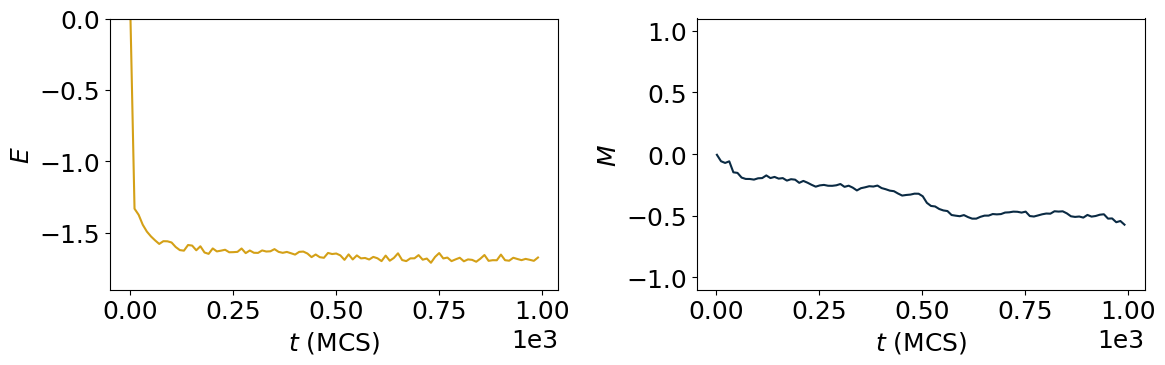

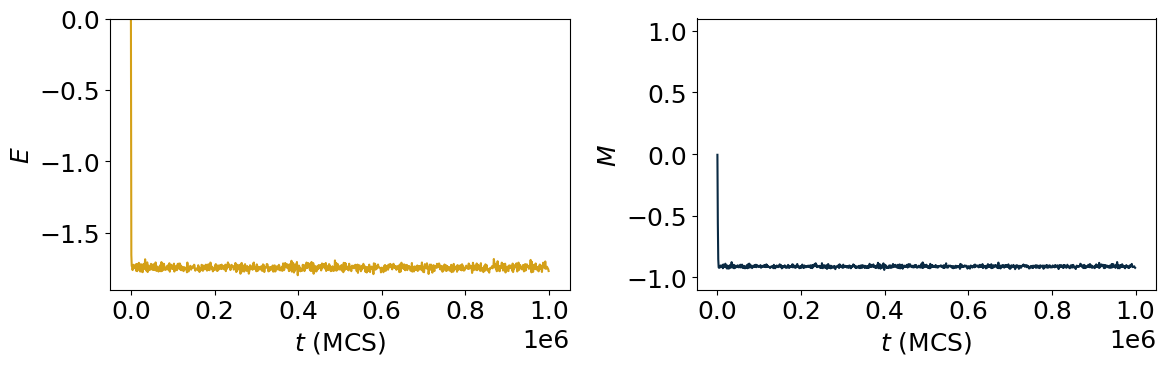

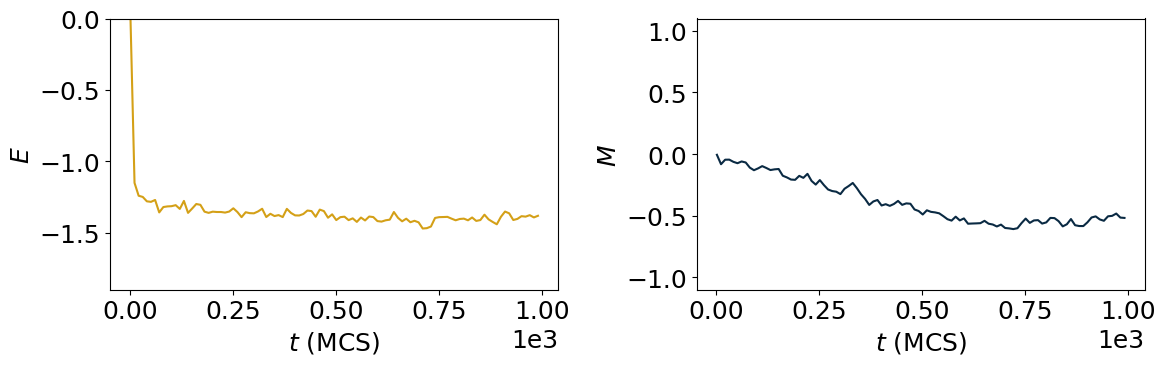

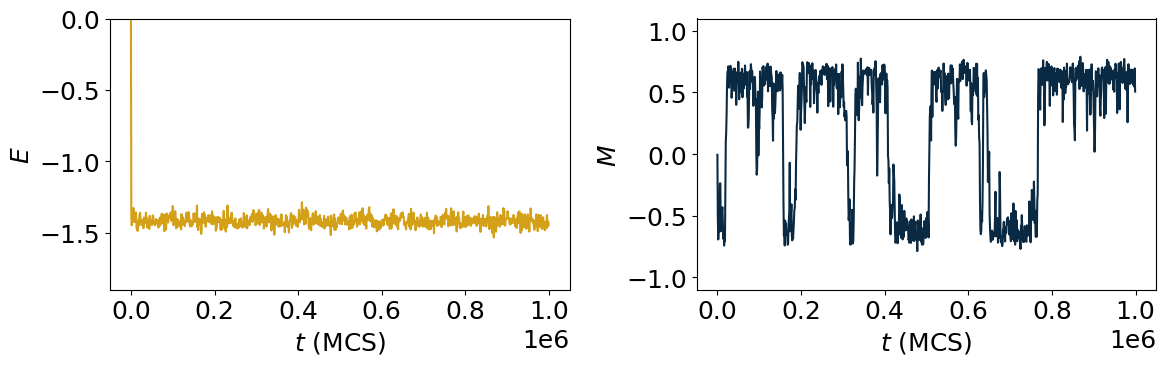

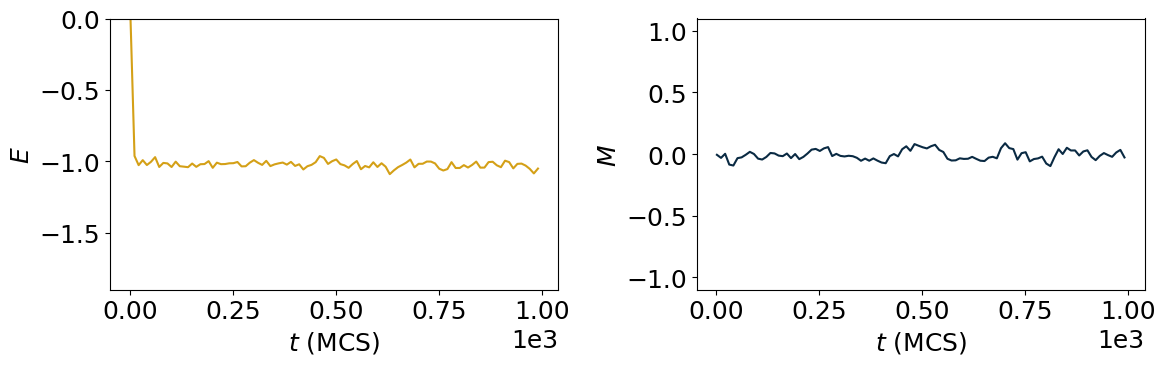

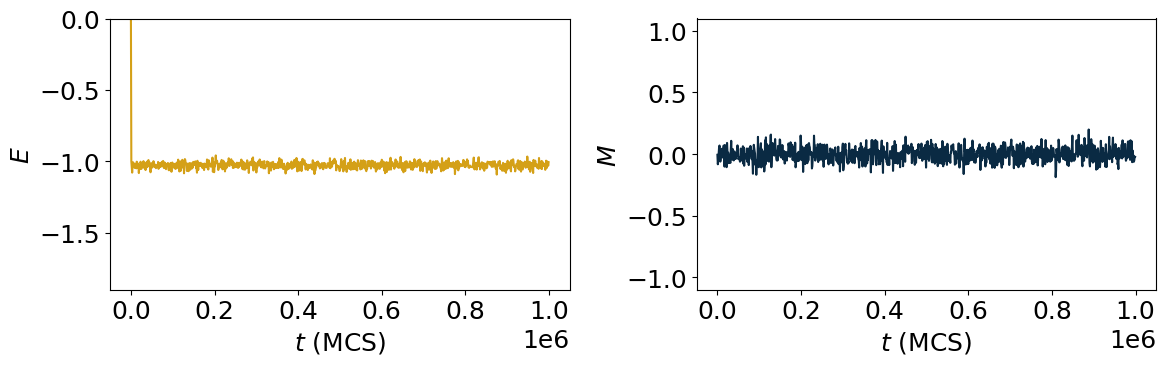

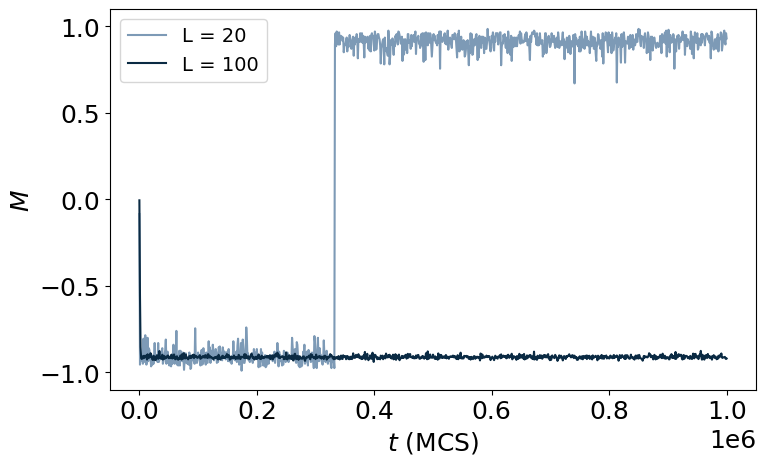

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -------------------------
# Configuración de Estilo
# -------------------------
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.autolayout': True
})

# -------------------------
# Parámetros
# -------------------------
nmeas = 10
T_values = [2.00, 2.27, 2.60]
path_L100 = "resultats_L_100/"

# Colores definidos
color_E = "#D4A017"        # mostaza
color_petroleo = "#0A2A43" # azul petróleo (Oscuro - para L=100)
color_acero = "#6F8FAE"     # azul acero (Más claro - para L=20)

# -------------------------
# Carga de datos
# -------------------------
def load_data(filename):
    try:
        data = np.loadtxt(filename)
        return data[:, 0], data[:, 1]
    except OSError:
        # Generador de datos dummy por si no existen los txt al probar
        N = 100000 
        return np.linspace(-1.5, -0.5, N), np.random.uniform(-1, 1, N)

# ==================================================
# 1) Series temporales L = 100
# ==================================================
for T in T_values:
    filename = path_L100 + f"results_MC_{T}_100.txt"
    E_full, M_full = load_data(filename)
    
    # ------------------------------------------------
    # A) Primeros 10^3 MCS
    # ------------------------------------------------
    idx_limit = int(1e3 / nmeas)
    steps_short = (np.arange(len(E_full[:idx_limit])) * nmeas) + 1
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # --- Energía ---
    ax = axes[0]
    ax.plot(steps_short, E_full[:idx_limit], color=color_E, linewidth=1.5)
    ax.set_ylabel(r"$E$")
    ax.set_xlabel(r"$t$ (MCS)")
    
    # CAMBIO AQUÍ: Límite ajustado a -1.8
    ax.set_ylim(-1.9, 0) 
    
    # Forzar notación científica x10^3
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # --- Magnetización ---
    ax = axes[1]
    ax.plot(steps_short, M_full[:idx_limit], color=color_petroleo, linewidth=1.5)
    ax.set_ylabel(r"$M$")
    ax.set_xlabel(r"$t$ (MCS)")
    ax.set_ylim(-1.1, 1.1)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # --- GUARDAR PDF (Serie Corta) ---
    plt.savefig(f"serie_corta_L100_T_{T}.pdf", bbox_inches='tight')
    
    plt.show()

    # ------------------------------------------------
    # B) Primeros 10^6 MCS (Diezmado)
    # ------------------------------------------------
    skip = 100
    max_mcs = 1e6
    idx_max = int(max_mcs / nmeas)
    
    E_plot = E_full[:idx_max:skip]
    M_plot = M_full[:idx_max:skip]
    steps_long = (np.arange(len(E_plot)) * skip * nmeas) + 1
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # --- Energía ---
    ax = axes[0]
    ax.plot(steps_long, E_plot, color=color_E, linewidth=1.5)
    ax.set_ylabel(r"$E$")
    ax.set_xlabel(r"$t$ (MCS)")
    
    # CAMBIO AQUÍ: Límite ajustado a -1.8
    ax.set_ylim(-1.9, 0)
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # --- Magnetización ---
    ax = axes[1]
    ax.plot(steps_long, M_plot, color=color_petroleo, linewidth=1.5)
    ax.set_ylabel(r"$M$")
    ax.set_xlabel(r"$t$ (MCS)")
    ax.set_ylim(-1.1, 1.1)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # --- GUARDAR PDF (Serie Larga) ---
    plt.savefig(f"serie_larga_L100_T_{T}.pdf", bbox_inches='tight')
    
    plt.show()


# ==================================================
# 2) Comparación L=20 vs L=100 a T = 2.0
# ==================================================
file_20 = "results_MC_2.00_20.txt" 
file_100 = path_L100 + "results_MC_2.00_100.txt"

E20, M20 = load_data(file_20)
E100, M100 = load_data(file_100)

skip = 100
M20_plot = M20[::skip]
steps20 = (np.arange(len(M20_plot)) * skip * nmeas) + 1

M100_plot = M100[::skip]
steps100 = (np.arange(len(M100_plot)) * skip * nmeas) + 1

plt.figure(figsize=(8, 5))

# Plot L=20 (Azul Acero - Más claro)
plt.plot(steps20, M20_plot, label="L = 20", color=color_acero, alpha=0.9, linewidth=1.5)

# Plot L=100 (Azul Petróleo - Más oscuro)
plt.plot(steps100, M100_plot, label="L = 100", color=color_petroleo, linewidth=1.5)

plt.xlabel(r"$t$ (MCS)")
plt.ylabel(r"$M$")
plt.ylim(-1.1, 1.1)
plt.legend(frameon=True, fontsize=14)

# Forzar notación científica para ver el 1e6
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# --- GUARDAR PDF (Comparación) ---
plt.savefig("comparacion_L20_vs_L100_T_2.00_new.pdf", bbox_inches='tight')

plt.show()